
#### Running a few different NLP models to understand customer concerns in the ski industry.

#### Questions:


### Imports

In [8]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import wordnet
from transformers import pipeline




# For using with google collab
# from google.colab import drive
# drive.mount('/content/drive')



### Loading Dataset

In [9]:

# Read the CSV file
file_path = 'C:/Users/matt/Downloads/OnTheSnow_SkiAreaReviews.csv'
skiraw = pd.read_csv(file_path)
print(skiraw.head())

# Filter out unwanted columns
skiraw2 = skiraw[['State', 'Ski Area', 'Review Star Rating (out of 5)', 'Review Text']]

# Display the first few rows of the new DataFrame to verify
print(skiraw2.head())

   Unnamed: 0       State          Ski Area  Reviewer Name  \
0           0  california  squaw-valley-usa  philip sayles   
1           1  california  squaw-valley-usa    mateonelson   
2           2  california  squaw-valley-usa            NaN   
3           3  california  squaw-valley-usa   Ivan Cazares   
4           4  california  squaw-valley-usa        welzbob   

          Review Date  Review Star Rating (out of 5)  \
0  31st December 2019                              3   
1       22nd May 2019                              4   
2      7th March 2019                              2   
3      5th March 2019                              3   
4  26th February 2019                              3   

                                         Review Text  
0  I'm glad our family experienced Squaw but I wo...  
1  I went skiing today 5/22, granite chief was am...  
2  We had a horrible experience on our family ski...  
3  This is the first year I ski Squaw. I've been ...  
4  Both Squaw a

### Cleaning Data

In [10]:
# Check for null values
null_values = skiraw2.isnull().sum()
print("Null values in each column:\n", null_values)

# Remove reviews without text because this is NLP based
ski_cleaned = skiraw2.dropna(subset=['Review Text'])

# Check for Null values again
null_values = ski_cleaned.isnull().sum()
print("Null values in each column:\n", null_values)

# Convert review text column to string
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)

# Verify the conversion
print(ski_cleaned['Review Text Cleaned'].dtype)


Null values in each column:
 State                             0
Ski Area                          0
Review Star Rating (out of 5)     0
Review Text                      12
dtype: int64
Null values in each column:
 State                            0
Ski Area                         0
Review Star Rating (out of 5)    0
Review Text                      0
dtype: int64
object


C:\Users\matt\AppData\Local\Temp\ipykernel_16308\3606133100.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text'].astype(str)


## Visualizing Raw Data

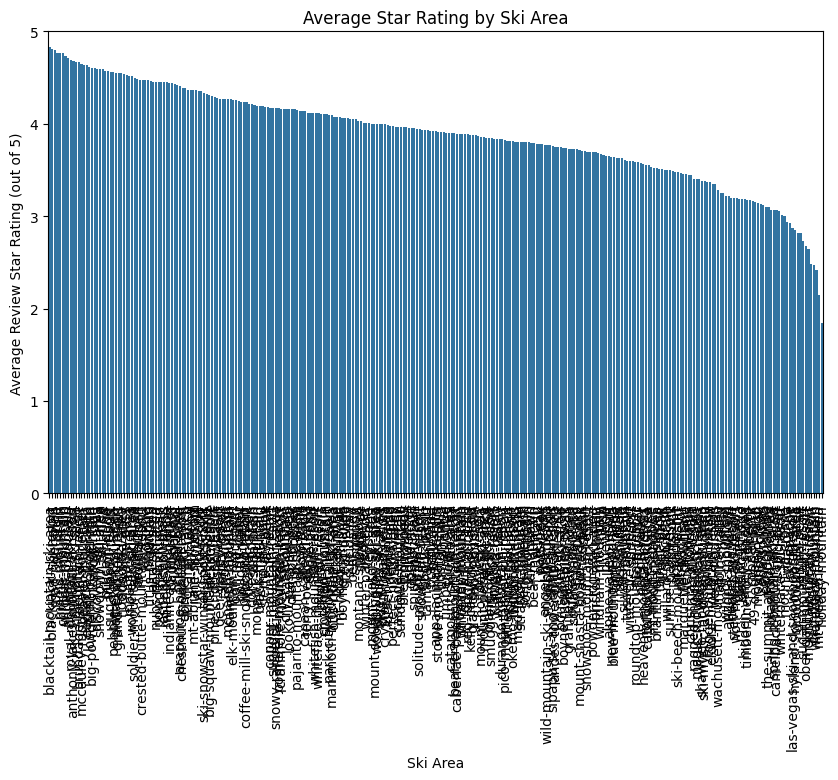

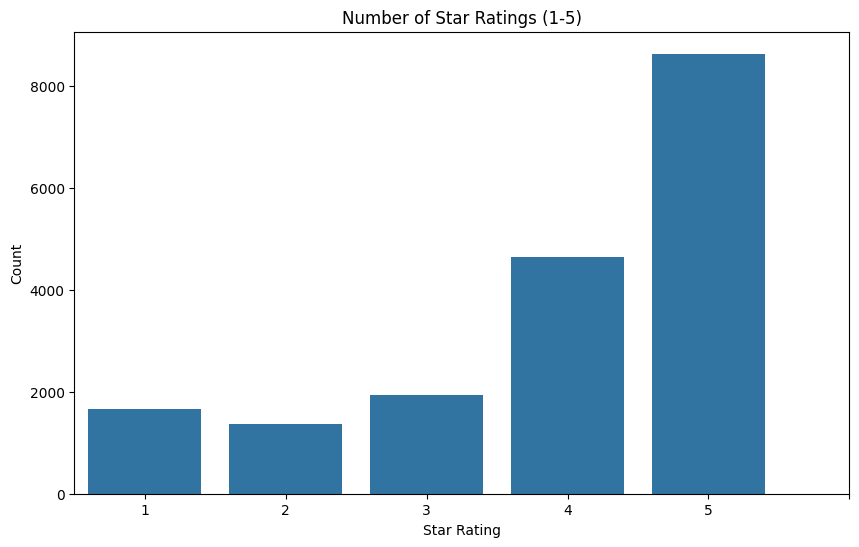

In [11]:
# Bar plot for the average star rating by ski area, sorted by descending order
plt.figure(figsize=(10, 6))
average_ratings = ski_cleaned.groupby('Ski Area')['Review Star Rating (out of 5)'].mean().reset_index()
average_ratings = average_ratings.sort_values(by='Review Star Rating (out of 5)', ascending=False)
sns.barplot(data=average_ratings, x='Ski Area', y='Review Star Rating (out of 5)')
plt.title('Average Star Rating by Ski Area')
plt.xlabel('Ski Area')
plt.ylabel('Average Review Star Rating (out of 5)')
plt.ylim(0, 5)
plt.xticks(rotation=90)
plt.show()

# Plot the number of star ratings from 1 to 5
plt.figure(figsize=(10, 6))
sns.countplot(data=ski_cleaned, x='Review Star Rating (out of 5)')
plt.title('Number of Star Ratings (1-5)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5])
plt.show()

### Takeaways
- Every ski resort has an average of above 2 stars
- The distibution of review star ratings leans heavily towards positive ratings

## Extracting Positive and Negative Features Using Sentiment Analysis

### Data cleaning for sentiment Analysis

In [12]:
# Data cleaning for sentiment analysis
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '', regex=True)
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.lower()

# Remove stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# Tokenize text
nltk.download('punkt')
ski_cleaned['tokens'] = ski_cleaned['Review Text Cleaned'].apply(word_tokenize)

# Lemmatize tokens
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

ski_cleaned['tokens'] = ski_cleaned['tokens'].apply(lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in x])

# Join tokens back to a string
ski_cleaned['final_text'] = ski_cleaned['tokens'].apply(lambda x: ' '.join(x))


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\matt\AppData\Local\Temp\ipykernel_16308\2467288695.py:2: SyntaxWarning: invalid escape sequence '\w'
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('[^\w\s]', '', regex=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_16308\2467288695.py:3: SyntaxWarning: invalid escape sequence '\d'
  ski_cleaned['Review Text Cleaned'] = ski_cleaned['Review Text Cleaned'].str.replace('\d+', '', regex=True)
C:\Users\matt\AppData\Local\Temp\ipykernel_16308\2467288695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sk

### Running Seniment On Tokens using pre-trained model for labeling

In [21]:
# Using Transformers for sentiment
from transformers import pipeline

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Truncate text to 592 tokens to avoid runtime errors
max_length = 396

# Function to truncate text
def truncate_text(text, max_length):
    tokens = word_tokenize(text)
    if len(tokens) > max_length:
        tokens = tokens[:max_length]
    return ' '.join(tokens)

# Apply the truncation function to the final_text
ski_cleaned['final_text_truncated'] = ski_cleaned['final_text'].apply(lambda x: truncate_text(x, max_length))

# Verify truncation
print(ski_cleaned['final_text_truncated'].apply(lambda x: len(word_tokenize(x))).max())

# Apply the pipeline to the data
chunk_size = 500  # Adjust this size based on your system's capabilities
results = []
for i in range(0, len(ski_cleaned['final_text_truncated']), chunk_size):
    chunk = ski_cleaned['final_text_truncated'][i:i+chunk_size]
    results.extend(sentiment_pipeline(chunk.tolist()))

# Add Transformers sentiment results to the dataframe
ski_cleaned['transformers_sentiment'] = [result['label'] for result in results]
ski_cleaned['transformers_score'] = [result['score'] for result in results]

# Print the head of the cleaned dataframe
print(ski_cleaned.head())



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\matt\AppData\Local\Temp\ipykernel_16308\747386959.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['final_text_truncated'] = ski_cleaned['final_text'].apply(lambda x: truncate_text(x, max_length))


396
        State          Ski Area  Review Star Rating (out of 5)  \
0  california  squaw-valley-usa                              3   
1  california  squaw-valley-usa                              4   
2  california  squaw-valley-usa                              2   
3  california  squaw-valley-usa                              3   
4  california  squaw-valley-usa                              3   

                                         Review Text  \
0  I'm glad our family experienced Squaw but I wo...   
1  I went skiing today 5/22, granite chief was am...   
2  We had a horrible experience on our family ski...   
3  This is the first year I ski Squaw. I've been ...   
4  Both Squaw and Alpine have incredible terrain,...   

                                 Review Text Cleaned  \
0  im glad family experienced squaw wont return n...   
1  went skiing today granite chief amazing new sn...   
2  horrible experience family ski vacation plenty...   
3  first year ski squaw ive couple sun

C:\Users\matt\AppData\Local\Temp\ipykernel_16308\747386959.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['transformers_sentiment'] = [result['label'] for result in results]
C:\Users\matt\AppData\Local\Temp\ipykernel_16308\747386959.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ski_cleaned['transformers_score'] = [result['score'] for result in results]


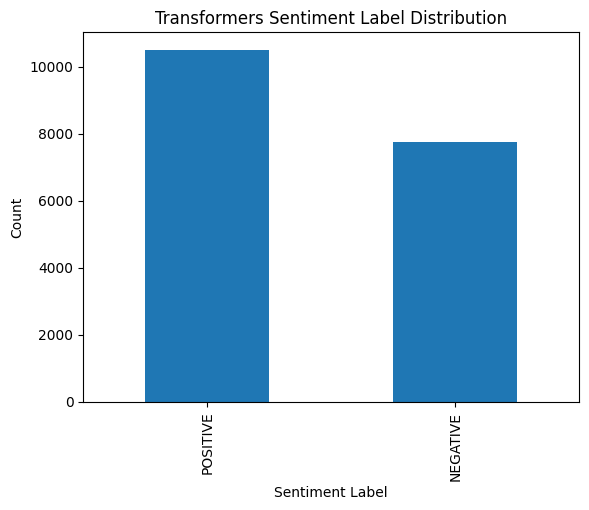

In [20]:


# Display sentiment label distribution for Transformers
ski_cleaned['transformers_sentiment'].value_counts().plot(kind='bar')
plt.title('Transformers Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

### Comments on sentiment label
#### Sentiment score is overwhelmingly positive compared to star rating, may be worth including neutural data in analysis to have more information

In [ ]:
ski_cleaned.head()

,State,Ski Area,Review Star Rating (out of 5),Review Text,Review Text Cleaned,tokens,final_text,sentiment,compound,sentiment_label
0,california,squaw-valley-usa,3,I'm glad our family experienced Squaw but I wo...,i'm glad family experienced squaw wont return ...,"[i, 'm, glad, family, experienced, squaw, wont...",i 'm glad family experienced squaw wont return...,"{'neg': 0.2, 'neu': 0.632, 'pos': 0.169, 'comp...",-0.6697,negative
1,california,squaw-valley-usa,4,"I went skiing today 5/22, granite chief was am...","went skiing today 5/22, granite chief amazing,...","[go, skiing, today, 5/22, ,, granite, chief, a...","go skiing today 5/22 , granite chief amaze , n...","{'neg': 0.0, 'neu': 0.859, 'pos': 0.141, 'comp...",0.8658,positive
2,california,squaw-valley-usa,2,We had a horrible experience on our family ski...,horrible experience family ski vacation here. ...,"[horrible, experience, family, ski, vacation, ...",horrible experience family ski vacation here ....,"{'neg': 0.137, 'neu': 0.863, 'pos': 0.0, 'comp...",-0.5423,negative
3,california,squaw-valley-usa,3,This is the first year I ski Squaw. I've been ...,first year ski squaw. i've couple sunny powder...,"[first, year, ski, squaw, ., i, 've, couple, s...",first year ski squaw . i 've couple sunny powd...,"{'neg': 0.076, 'neu': 0.596, 'pos': 0.327, 'co...",0.9973,positive
4,california,squaw-valley-usa,3,"Both Squaw and Alpine have incredible terrain,...","squaw alpine incredible terrain, impressive sn...","[squaw, alpine, incredible, terrain, ,, impres...","squaw alpine incredible terrain , impressive s...","{'neg': 0.099, 'neu': 0.739, 'pos': 0.162, 'co...",0.6597,positive


### Sorting Reviews out based on sentiment label for topic modeling